# Wrfcf Average Tmax/Tmin

In [1]:
# imports
import numpy
import Nio
import Ngl
from IPython import display
import netCDF4 as nc
from datetime import date
from datetime import timedelta
import xarray as xr
import xesmf as xe

In [2]:
# reading in wrfcf tmaxes, change to tmins to see tmins
wrf_05 = xr.open_dataset('./wrf_05_tmin.nc')
wrf_06 = xr.open_dataset('./wrf_06_tmin.nc')
wrf_07 = xr.open_dataset('./wrf_07_tmin.nc')
wrf_08 = xr.open_dataset('./wrf_08_tmin.nc')
wrf_09 = xr.open_dataset('./wrf_09_tmin.nc')
wrf_10 = xr.open_dataset('./wrf_10_tmin.nc')
wrf_11 = xr.open_dataset('./wrf_11_tmin.nc')
wrf_12 = xr.open_dataset('./wrf_12_tmin.nc')
wrf_13 = xr.open_dataset('./wrf_13_tmin.nc')
wrf_14 = xr.open_dataset('./wrf_14_tmin.nc')
wrf_15 = xr.open_dataset('./wrf_15_tmin.nc')
#wrf_16 = xr.open_dataset('./wrf_16.nc')
#wrf_17 = xr.open_dataset('./wrf_17.nc')
#wrf_17['maxes'] = wrf_17['T_2m']

#wrf_lst = [wrf_05, wrf_06, wrf_07, wrf_08, wrf_09, wrf_10, wrf_11, wrf_12, wrf_13, wrf_14, wrf_15, wrf_16, wrf_17]
wrf_lst = [wrf_05, wrf_06, wrf_07, wrf_08, wrf_09, wrf_10, wrf_11, wrf_12, wrf_13, wrf_14, wrf_15]

In [3]:
max(wrf_15['mins'].data.flatten())

292.18535493884457

In [4]:
# averaging
sum_arr = wrf_06['mins'].data
for i in wrf_lst[2:11]:
    sum_arr += i['mins'].data
avg = sum_arr / 10 #13
avg

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
# for reference
numpy.unique(avg), numpy.unique(sum_arr), numpy.unique(wrf_05['mins'])

(array([  0.        , 249.33291661, 249.35379292, ..., 291.42077391,
        291.47544618, 291.57994896]),
 array([   0.        , 2493.32916614, 2493.53792924, ..., 2914.20773914,
        2914.7544618 , 2915.7994896 ]),
 array([  0.        , 238.60335375, 239.28988535, ..., 289.63240683,
        289.63817602, 289.6750986 ]))

In [6]:
# change 0.0 to NaNs
avg[avg == 0.0] = 'nan'

In [7]:
# janky way to find average using livneh coords, subtracting wrf avg/pt by random 
# livneh to create nans then adding livneh avg/pt back so we can remove wrf pts not in common
fn = '/cw3e/mead/projects/cwp103/scratch/ldehaan/Livneh/ptt_2017.nc'
liv = xr.open_dataset(fn)
livran = liv['Tmin'][35]
sub = numpy.subtract(avg, livran)
new_add = numpy.add(sub, livran)
numpy.unique(avg), numpy.unique(sub), numpy.unique(new_add)

(array([249.33291661, 249.35379292, 249.40179611, ...,          nan,
                 nan,          nan]),
 array([262.56511876, 262.85364185, 263.02135613, ...,          nan,
                 nan,          nan]),
 array([249.33291661, 249.35379292, 249.40179611, ...,          nan,
                 nan,          nan]))

In [8]:
# convert dif_arr to masked array to overlook NaNs
import numpy.ma as ma
m_out = ma.masked_invalid(new_add)
m_out

masked_array(
  data=[[--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        ...,
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --],
        [--, --, --, ..., --, --, --]],
  mask=[[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]],
  fill_value=1e+20)

In [9]:
# convert from K to C
m_out = m_out - 273.15
min(numpy.unique(m_out))

-23.81708338612043

In [10]:
# numerical average over entire region
numpy.mean(m_out.flatten())

-2.29265485976216

In [11]:
# workstation
wks_type = "png"
wks = Ngl.open_wks(wks_type,"wrfcf17_avg_tmin_NG-GR-NQ-BD")

In [12]:
# defining variables
fn = '/cw3e/mead/projects/cwp103/production/output/2017020500/cf/NG-GR-NQ-BD/wrfcf_d02_2017-02-05_22_00_00.nc'
cdf_file1 = Nio.open_file(fn, "r")
temp = m_out
tlo = cdf_file1.variables["lon"][:].flatten()
tla = cdf_file1.variables["lat"][:].flatten()
tmax_lon  =  wrf_05['lon'].data.flatten()
tmax_lat  =  wrf_05['lat'].data.flatten()
tmax_nlon =  len(tmax_lon)
tmax_nlat =  len(tmax_lat)

In [13]:
# XY of overlay plot
resources = Ngl.Resources()

# fill missing values as needed
if hasattr(temp,"_FillValue"):
    resources.sfMissingValueV = temp[0]._FillValue

resources.sfXCStartV = min(tmax_lon)
resources.sfXCEndV   = max(tmax_lon)
resources.sfYCStartV = min(tmax_lat)
resources.sfYCEndV   = max(tmax_lat)

# cmap
resources.cnLevelSelectionMode = "ManualLevels"
resources.cnMinLevelValF       = -20
resources.cnMaxLevelValF       = 32
resources.cnLevelSpacingF      = 4

# plot styling
resources.mpFillOn              = True
resources.mpFillAreaSpecifiers  = ["Water","Land","USStatesWater"]
resources.mpSpecifiedFillColors = [0,0,0]
resources.mpAreaMaskingOn       = True            
resources.mpMaskAreaSpecifiers  = "USStatesLand"
resources.cnFillDrawOrder       = "Predraw" 
Ngl.set_values(wks,resources)
resources.tiXAxisString = "~F25~Longitude"
resources.tiYAxisString = "~F25~Latitude"
resources.cnFillOn              = True    
resources.cnLineLabelsOn        = False  
resources.cnInfoLabelOn         = False  
resources.nglSpreadColorEnd     = -2
resources.mpProjection = "LambertEqualArea" 
resources.mpCenterLonF = (tmax_lon[tmax_nlon-1] + tmax_lon[0])/2
resources.mpCenterLatF = (tmax_lat[tmax_nlat-1] + tmax_lat[0])/2
resources.mpLimitMode = "LatLon"
resources.mpMinLonF   = min(tlo)
resources.mpMaxLonF   = max(tlo)
resources.mpMinLatF   = min(tla)
resources.mpMaxLatF   = max(tla)
resources.mpPerimOn   = True
resources.cnLinesOn   = False
resources.mpOutlineBoundarySets = "GeophysicalAndUSStates"
resources.pmTickMarkDisplayMode = "Never"
resources.tiMainString = "~F26~Wrfcf Average Tmin, 2017-02-05 to 2017-02-17, NG-GR-NQ-BD"
resources.lbOrientation  = "Horizontal"
resources.lbTitleString  = "~F25~Temp (C)"   

In [14]:
# plot
map = Ngl.contour_map(wks,temp,resources)

In [15]:
# clean up
del map
del resources
Ngl.end()

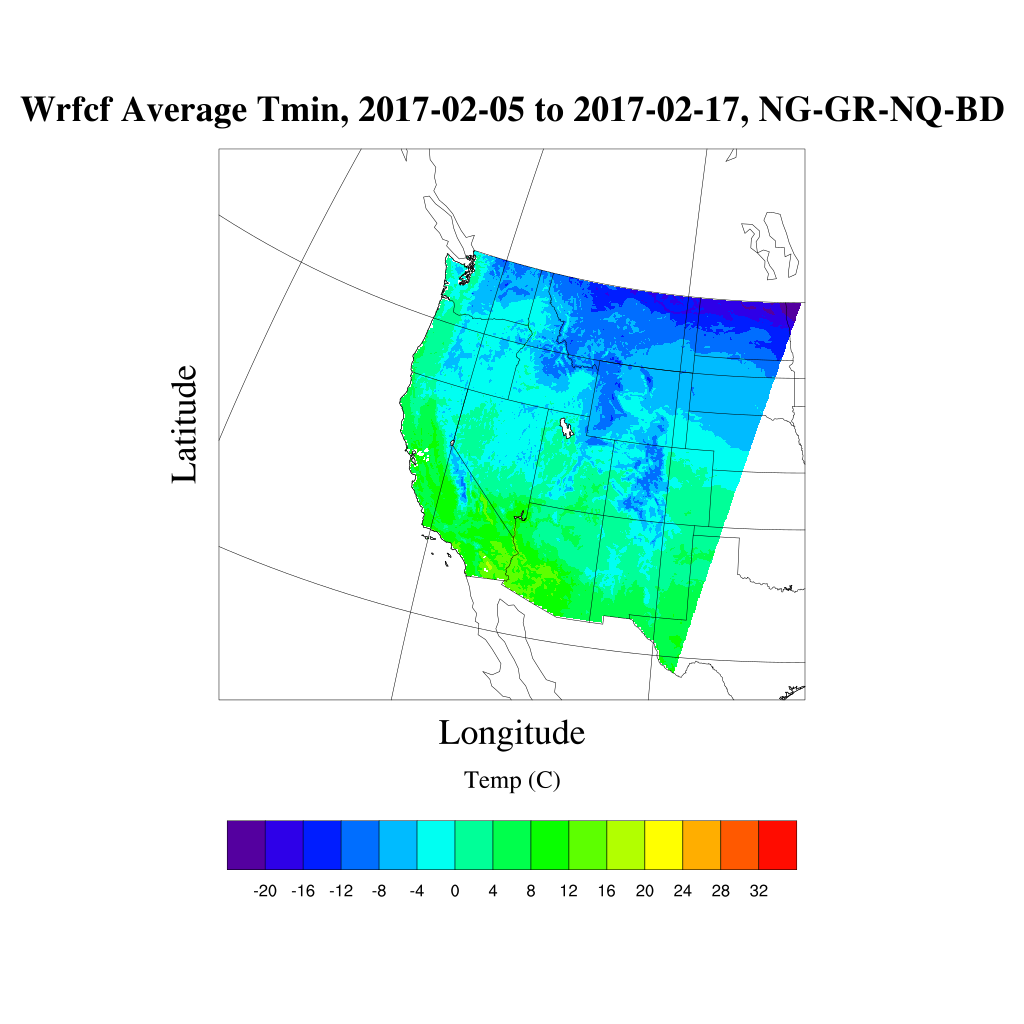

In [16]:
# display plot (needs further cleaning later)
display.Image("./wrfcf17_avg_tmin_NG-GR-NQ-BD.png")

fin.